# Inspect Results of all 10-Fold RF SDEP Runs

<hr/>

#### Imports

In [1]:
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ensemble_uncertainties.utils.ad_assessment import spearman_coeff

from sklearn.metrics import r2_score

from statistics import median

#### Constants

In [2]:
DATA_FOLDER = '../../../data/featurized/'
ENSEMBLE_DATA_FOLDER = '../../../data/generated_by_notebooks/'
RF_SDEP_RESULTS_FOLDER = '../../../data/results/rf_sdep/'
PLOT_FOLDER = './plots/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_names = ['RF', 'XGB', 'SVM', 'Shallow', 'Deep']
algorithm_to_name = dict(zip(algorithms, algorithm_names))

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'ECFC', 'RDKit', 'CDDD']
descriptor_to_name = dict(zip(descriptors, descriptor_names))

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def load_rf_sdep_results_file(name, descriptor):
    """Loads table with RF SDEP predictions and uncertainties for a given dataset/descriptor."""
    path = f'{RF_SDEP_RESULTS_FOLDER}{name}/{descriptor}/results.csv'
    results_df = pd.read_csv(path, sep=';').set_index('id')
    return results_df


def load_evaluation_matrix(name, evaluation='predictive', to_matrix=True):
    """Loads performance table for a single dataset."""
    path = f'{ENSEMBLE_DATA_FOLDER}/{evaluation}_performances/{name}.csv'
    df = pd.read_csv(path, sep=';').set_index('descriptor')
    if to_matrix:
        matrix = df.to_numpy()
        return matrix
    else:
        return df
    
    
def make_y_range(yrange, interval=.1):
    """Creates a range between yrange[0] and yrange[1] with a given interval."""
    factor = 1./interval
    ylow = int(factor * yrange[0])
    yhigh = int(factor * yrange[1])
    rang = range(ylow, yhigh+1)
    rang_adjusted = [np.round(val*interval, 1) for val in rang]
    return rang_adjusted

<hr/>

#### Load data

In [5]:
rf_sdep_result_tables = dict()

for dataset in dataset_names:
    for descriptor in descriptors:
        results_df = load_rf_sdep_results_file(dataset, descriptor)
        results_df['y'] = load_true(dataset)
        rf_sdep_result_tables[f'{dataset}_{descriptor}'] = results_df

#### Collect overviews

RF SDEP

In [6]:
complete_overview_rf_sdep = pd.DataFrame()

names = list()
descs = list()
r2_values = list()
rho_values = list()

for dataset in dataset_names:
    for descriptor in descriptors:
        names.append(dataset)
        descs.append(descriptor_to_name[descriptor])
        df = rf_sdep_result_tables[f'{dataset}_{descriptor}']
        r2_values.append(r2_score(df['y'], df['predicted']))
        rho_values.append(spearman_coeff(df['resid'], df['uq']))

complete_overview_rf_sdep['name'] = names
complete_overview_rf_sdep['descriptor'] = descs
complete_overview_rf_sdep['r2'] = r2_values
complete_overview_rf_sdep['rho'] = rho_values

Ensembles

In [7]:
complete_overview_ensemble = pd.DataFrame()

names = list()
descs = list()
r2_values = list()
rho_values = list()

for dataset in dataset_names:
    r2_df = load_evaluation_matrix(dataset, evaluation='predictive', to_matrix=False)
    rho_df = load_evaluation_matrix(dataset, evaluation='uncertainty', to_matrix=False)
    for descriptor in descriptor_names:
        names.append(dataset)
        descs.append(descriptor)
        r2_values.append(r2_df['RF'][descriptor])
        rho_values.append(rho_df['RF'][descriptor])

complete_overview_ensemble['name'] = names
complete_overview_ensemble['descriptor'] = descs
complete_overview_ensemble['r2'] = r2_values
complete_overview_ensemble['rho'] = rho_values

#### Scatter plot

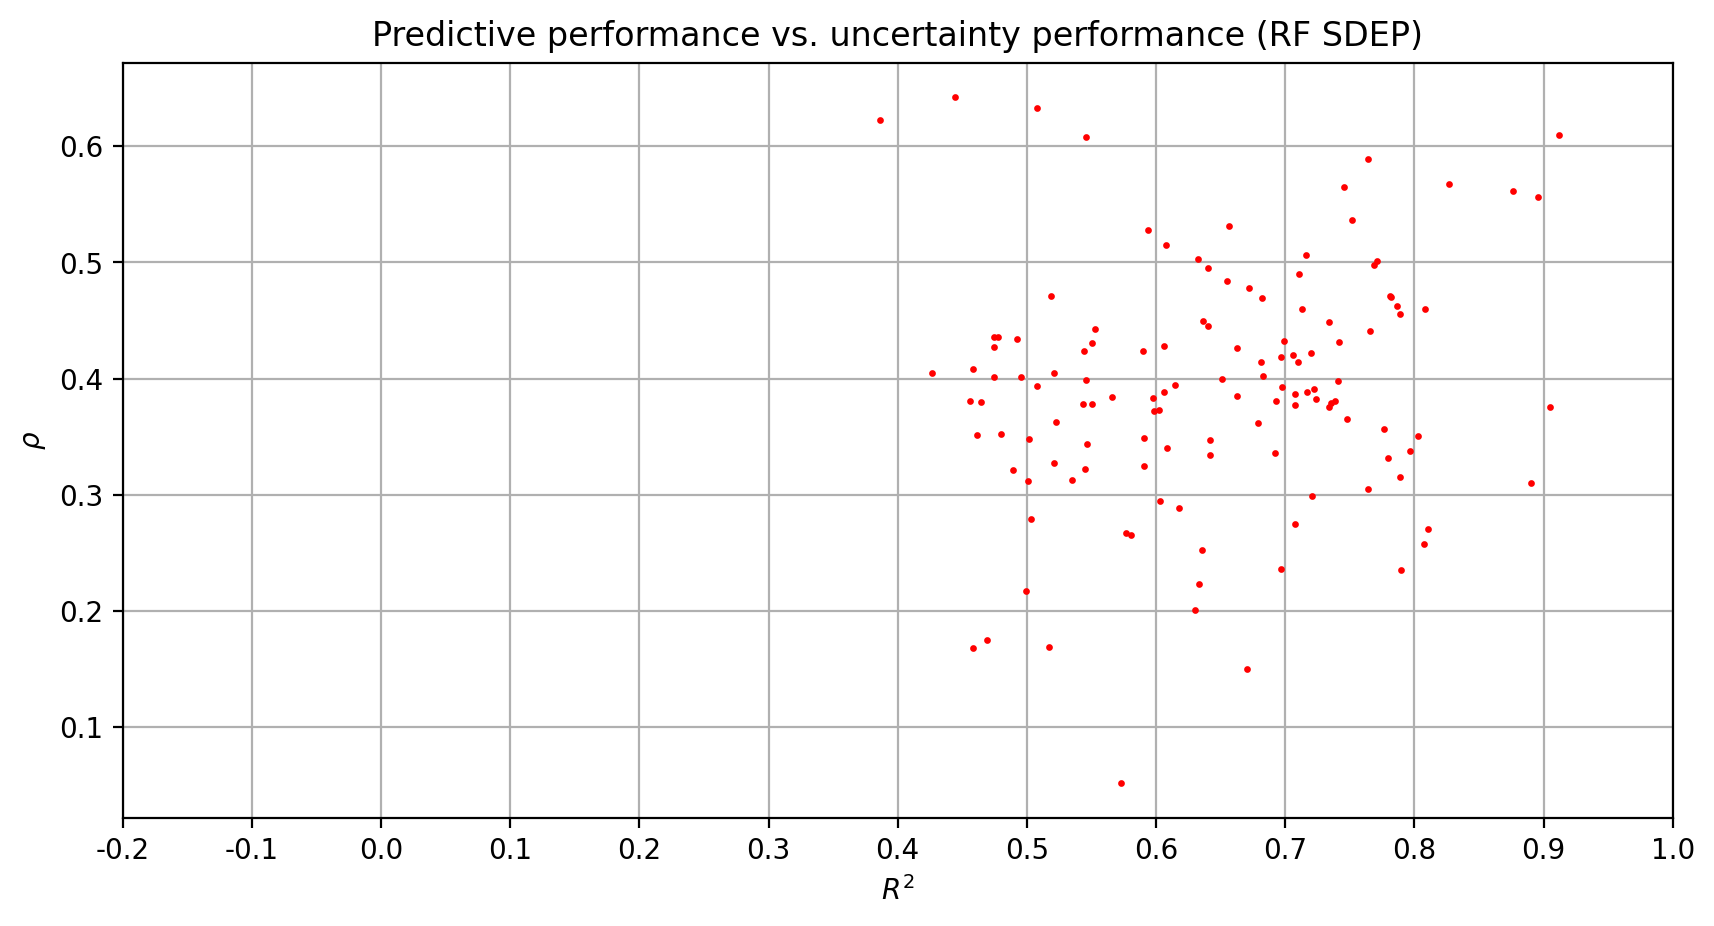

In [8]:
plt.figure(figsize=(10, 5))
plt.grid(zorder=1000)
plt.scatter(complete_overview_rf_sdep['r2'], complete_overview_rf_sdep['rho'], s=2, zorder=100, color='red')
plt.xlabel(r'$R^2$')
plt.xticks(np.arange(-.2, 1.1, .1), [f'{val:.1f}' for val in np.arange(-.2, 1.1, .1)])
plt.ylabel(r'$\rho$')
plt.title('Predictive performance vs. uncertainty performance (RF SDEP)')
plt.savefig(PLOT_FOLDER+'predictive_vs_uncertainty/rf_sdep_unselected_overview.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

#### Box-Whisker: RF SDEP vs. ensembles

Predictive performance

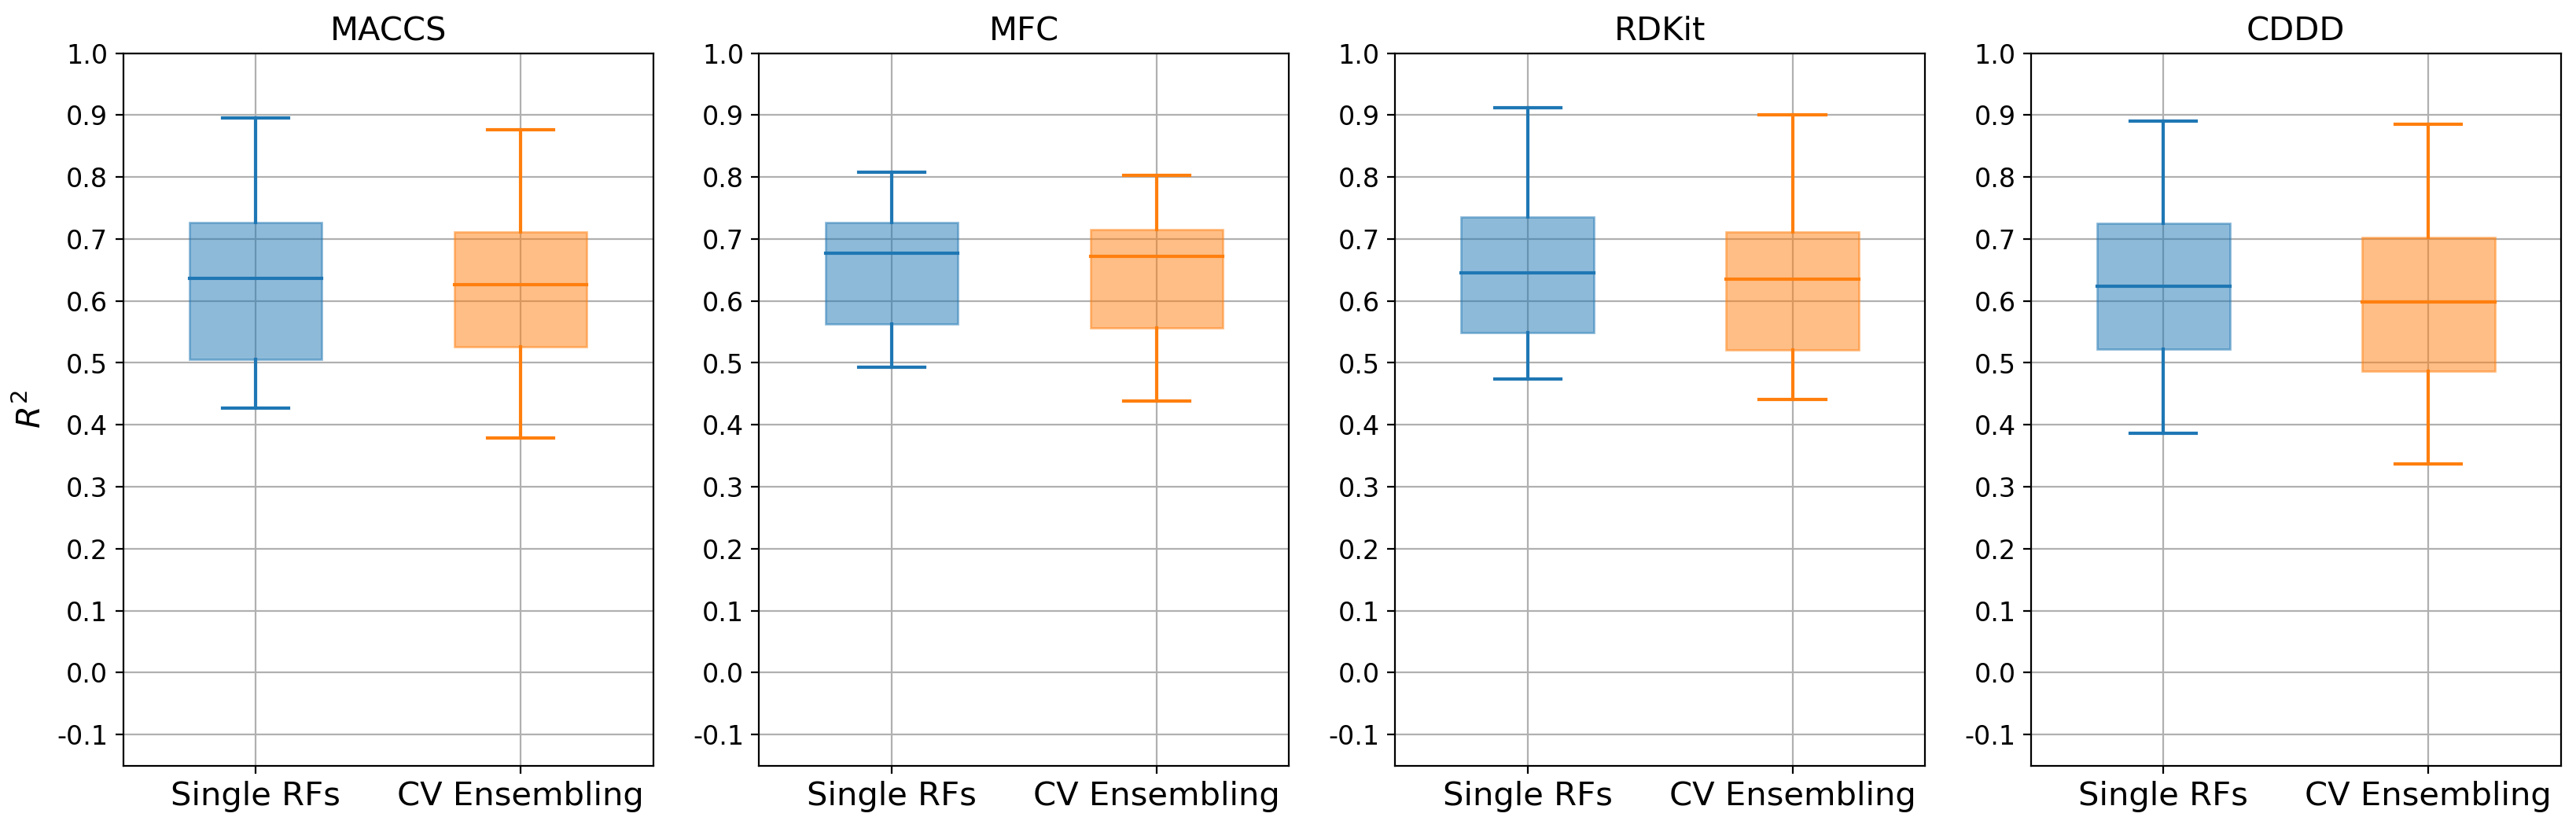

In [9]:
fix, axes = plt.subplots(1, len(descriptors), figsize=(20, 6))

corrected_descriptor_names = ['MACCS', 'MFC', 'RDKit', 'CDDD']

for i in range(len(axes)):
    ax = axes[i]
    descriptor = descriptor_names[i]
    title = corrected_descriptor_names[i]
    rf_sdep_table = complete_overview_rf_sdep[complete_overview_rf_sdep['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([rf_sdep_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['r2'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.15, 1.))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['Single RFs', 'CV Ensembling'], size=15)
    rang_adjusted = make_y_range((-.1, 1.))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted, size=12)
    if i == 0:
        ax.set_ylabel('$R^2$', size=15)
plt.savefig(PLOT_FOLDER+'rf_sdep_vs_ensemble/r2.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Uncertainty performance

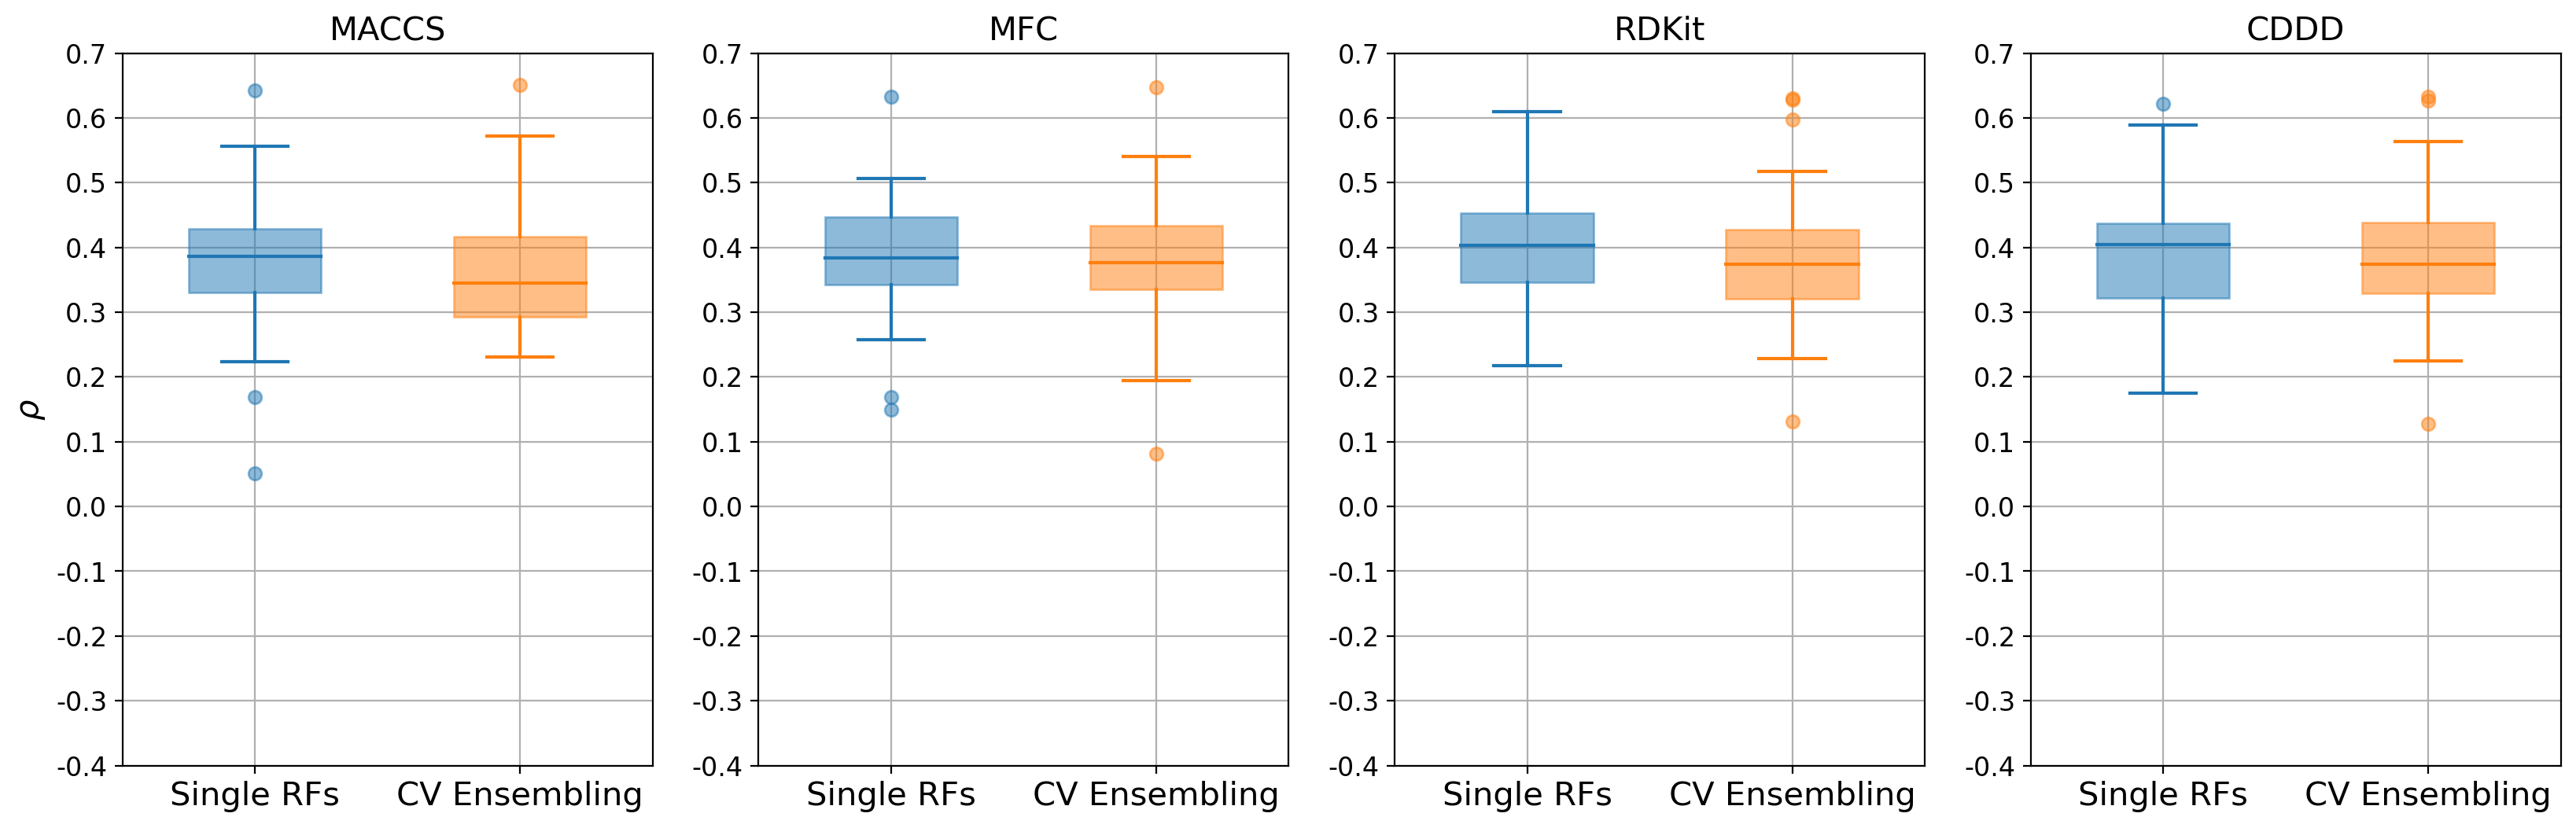

In [10]:
fix, axes = plt.subplots(1, len(descriptors), figsize=(20, 6))

for i in range(len(axes)):
    ax = axes[i]
    descriptor = descriptor_names[i]
    title = corrected_descriptor_names[i]
    rf_sdep_table = complete_overview_rf_sdep[complete_overview_rf_sdep['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([rf_sdep_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['rho'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.4, .7))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['Single RFs', 'CV Ensembling'], size=15)
    rang_adjusted = make_y_range((-.4, .7))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted, size=12)
    if i == 0:
        ax.set_ylabel(r'$\rho$', size=15)
plt.savefig(PLOT_FOLDER+'rf_sdep_vs_ensemble/rho.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Both

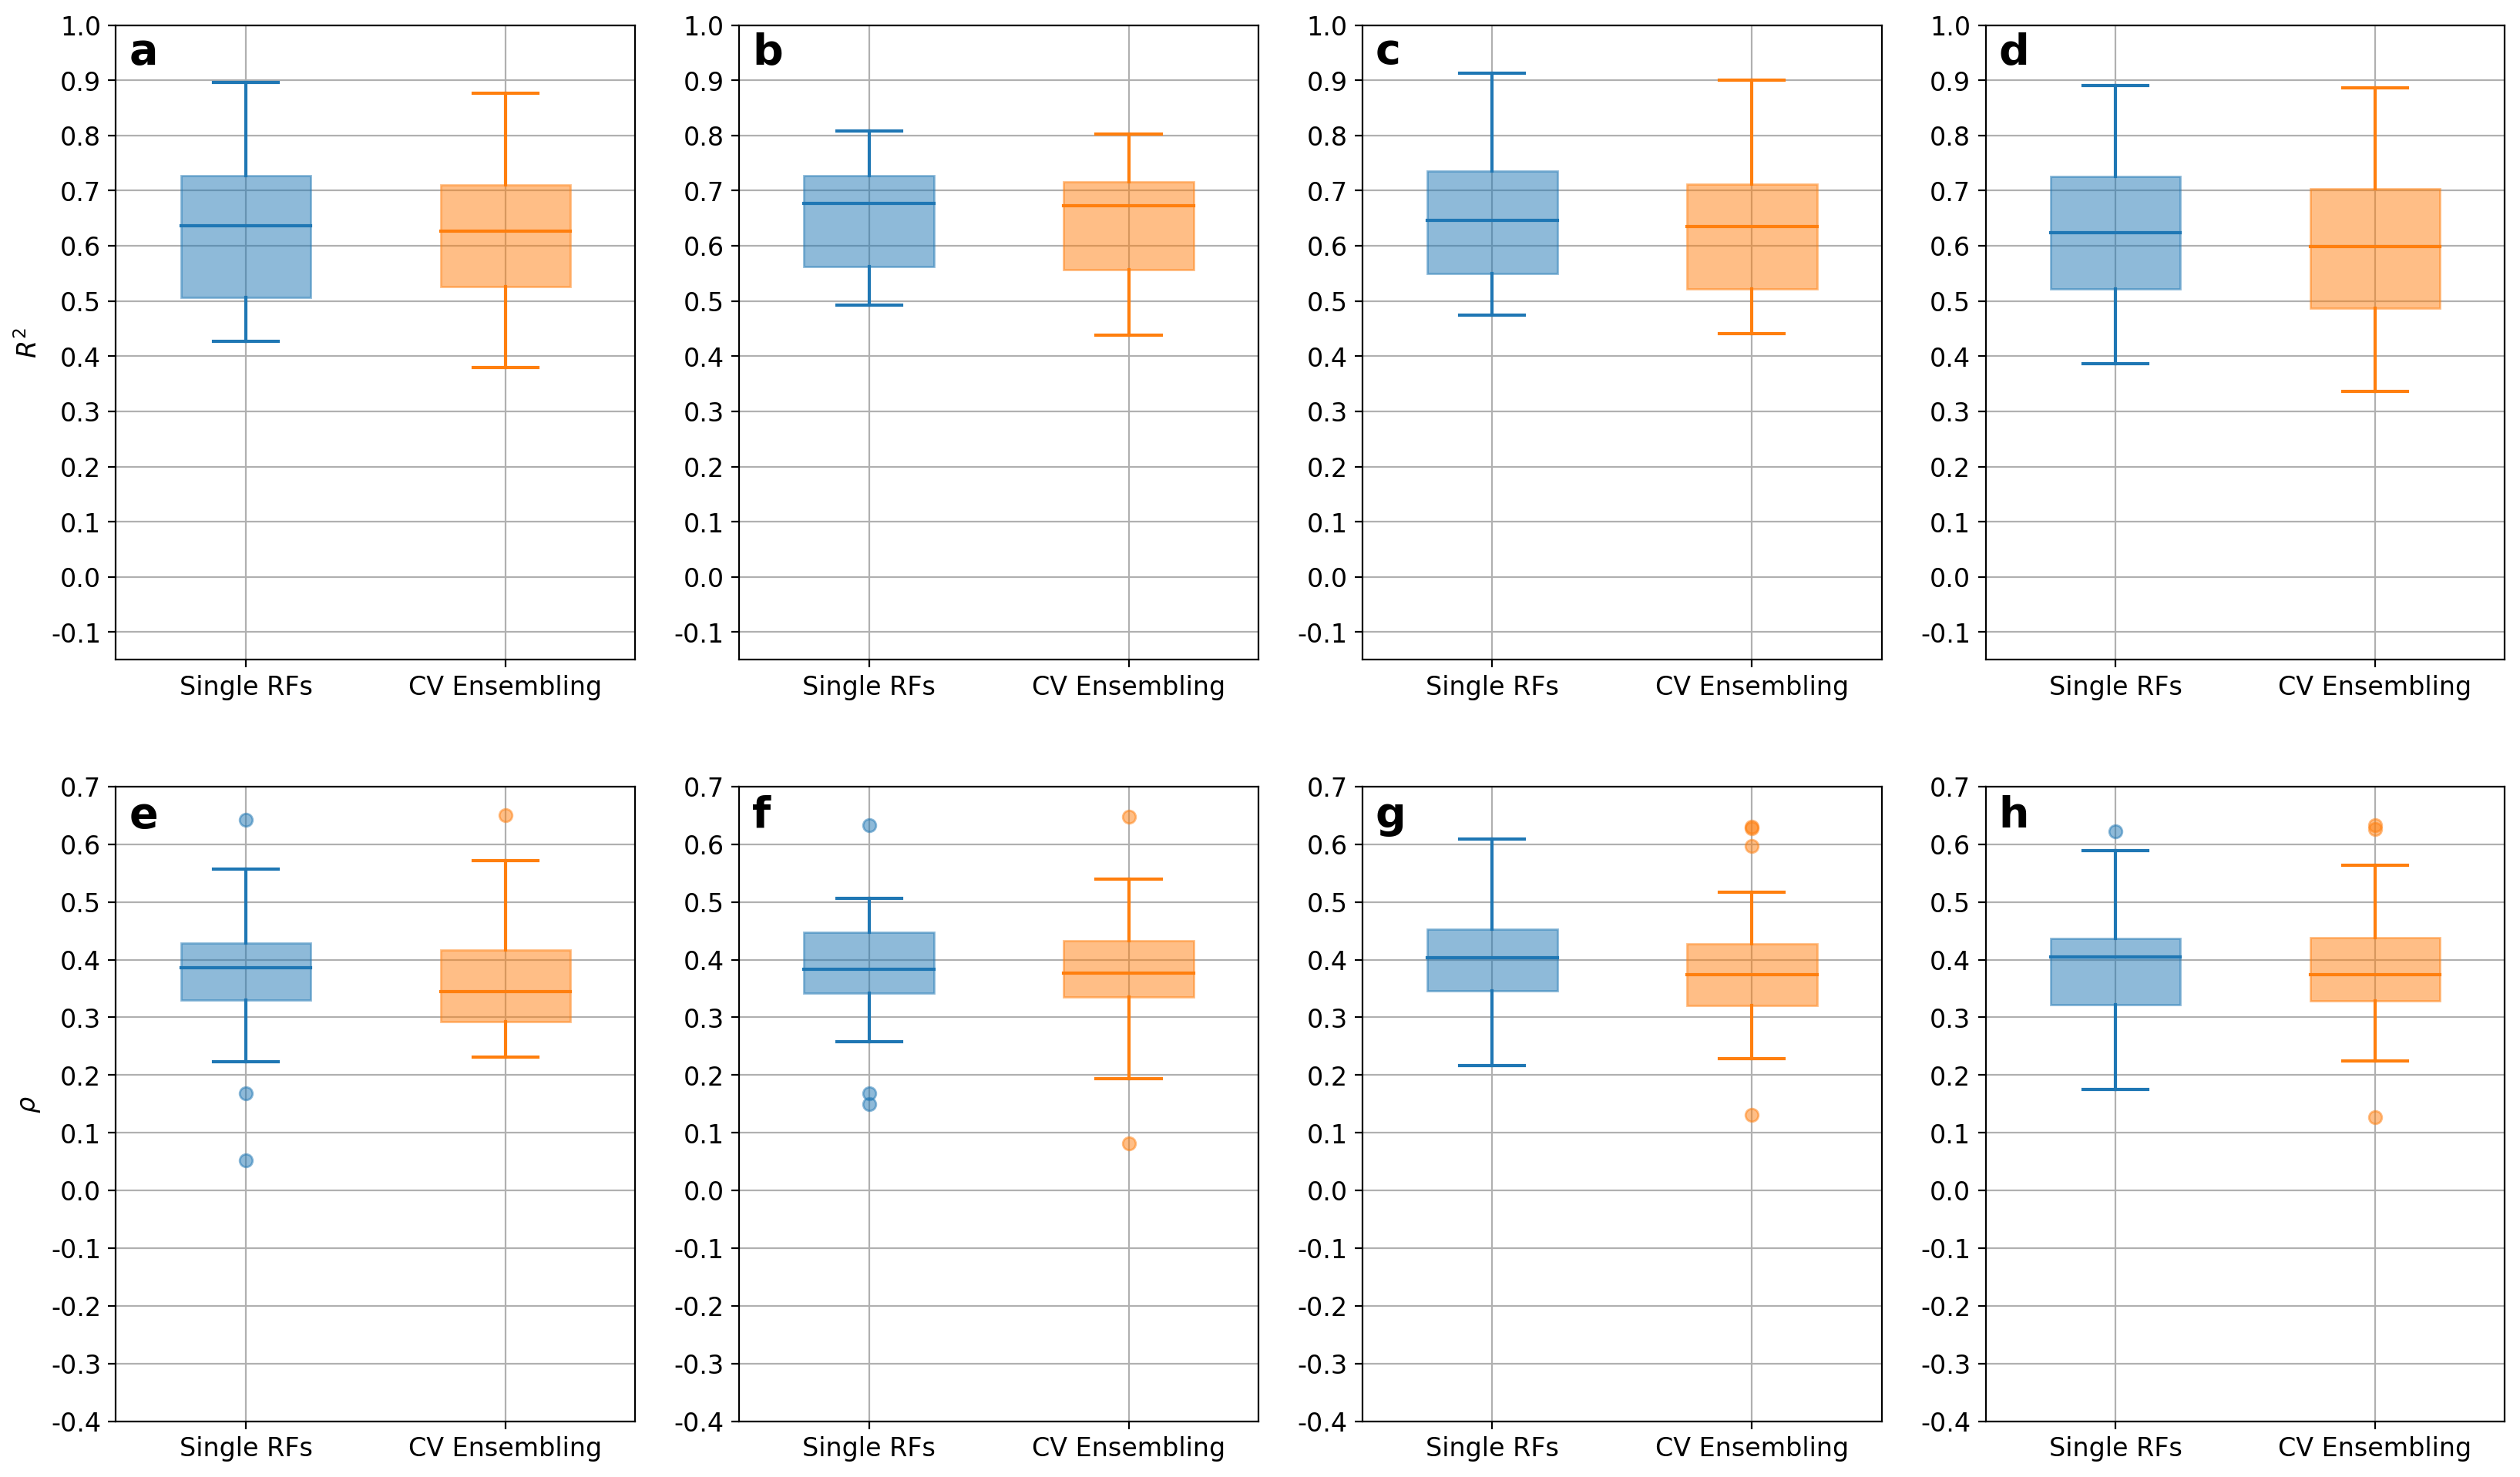

In [11]:
subpanel_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
subpanel_index = 0

fix, (r2_axes, rho_axes) = plt.subplots(2, len(descriptors), figsize=(20, 12))

for i in range(len(r2_axes)):
    ax = r2_axes[i]
    descriptor = descriptor_names[i]
    #title = corrected_descriptor_names[i]
    rf_sdep_table = complete_overview_rf_sdep[complete_overview_rf_sdep['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([rf_sdep_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['r2'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.15, 1.))
    #ax.set_title(title, size=15)
    ax.set_xticklabels(['Single RFs', 'CV Ensembling'])
    rang_adjusted = make_y_range((-.1, 1.))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted)
    plt.setp(ax.xaxis.get_majorticklabels(), size=12)
    plt.setp(ax.yaxis.get_majorticklabels(), size=12)
    ax.text(-.45, .93, subpanel_letters[subpanel_index], fontsize=20, weight='bold')
    subpanel_index += 1
    if i == 0:
        ax.set_ylabel('$R^2$', size=12)
        
for i in range(len(rho_axes)):
    ax = rho_axes[i]
    descriptor = descriptor_names[i]
    #title = corrected_descriptor_names[i]
    rf_sdep_table = complete_overview_rf_sdep[complete_overview_rf_sdep['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([rf_sdep_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['rho'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    #ax.set_ylim((-.4, .7))
    #ax.set_title(title, size=15)
    ax.set_xticklabels(['Single RFs', 'CV Ensembling'])
    rang_adjusted = make_y_range((-.4, .7))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted)
    plt.setp(ax.xaxis.get_majorticklabels(), size=12)
    plt.setp(ax.yaxis.get_majorticklabels(), size=12)
    ax.text(-.45, .63, subpanel_letters[subpanel_index], fontsize=20, weight='bold')
    subpanel_index += 1
    if i == 0:
        ax.set_ylabel(r'$\rho$', size=12)
        
plt.savefig(PLOT_FOLDER+'rf_sdep_vs_ensemble/rf_sdep_comparison_summary.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Compare RF SDEP performances with ensemble performances

In [12]:
rf_sdep_predictive = complete_overview_rf_sdep['r2'].values
rf_sdep_uncertainty = complete_overview_rf_sdep['rho'].values

ensemble_predictive = complete_overview_ensemble['r2'].values
ensemble_uncertainty = complete_overview_ensemble['rho'].values

pred_rf_better_than_ensembles = 0
pred_ensembles_better_than_rf = 0

pred_rf_ens_diffs = list()
pred_ens_rf_diffs = list()

print('?   RFS    Ens')
for r_p, e_p in zip(rf_sdep_predictive, ensemble_predictive):
    if r_p > e_p:
        print(f'   {r_p:.3f}  {e_p:.3f}')
        pred_rf_better_than_ensembles += 1
        pred_rf_ens_diffs.append(r_p - e_p)
    else:
        print(f'X  {r_p:.3f}  {e_p:.3f}')
        pred_ensembles_better_than_rf += 1
        pred_ens_rf_diffs.append(e_p - r_p)
        
print()
print(f'{pred_rf_better_than_ensembles} times, RF uncertainty achieved a higher predictive performance than ensembles.')
print(f'Differences range from {min(pred_rf_ens_diffs):.3f} to {max(pred_rf_ens_diffs):.3f}, with a median of {median(pred_rf_ens_diffs):.3f}.')
print(f'{pred_ensembles_better_than_rf} times, ensembles achieved a higher predictive performance than RF uncertainty.')
print(f'Differences range from {min(pred_ens_rf_diffs):.3f} to {max(pred_ens_rf_diffs):.3f}, with a median of {median(pred_ens_rf_diffs):.3f}.')

?   RFS    Ens
   0.782  0.759
   0.771  0.735
   0.827  0.800
   0.781  0.760
   0.896  0.876
   0.716  0.680
   0.912  0.885
   0.876  0.837
   0.803  0.787
   0.748  0.715
   0.905  0.901
   0.890  0.886
   0.462  0.425
   0.521  0.463
   0.475  0.441
   0.480  0.442
X  0.459  0.493
   0.517  0.497
X  0.500  0.501
   0.469  0.445
X  0.633  0.655
X  0.693  0.699
   0.707  0.698
X  0.697  0.699
   0.501  0.486
   0.547  0.541
   0.490  0.484
   0.503  0.472
   0.640  0.611
   0.713  0.687
   0.637  0.600
   0.607  0.569
   0.692  0.674
   0.708  0.689
   0.717  0.706
   0.699  0.672
X  0.614  0.622
   0.642  0.630
   0.663  0.642
   0.642  0.620
X  0.683  0.688
   0.706  0.700
   0.697  0.688
   0.663  0.642
   0.722  0.709
   0.724  0.700
   0.710  0.699
   0.681  0.657
   0.698  0.688
   0.735  0.722
   0.710  0.688
   0.679  0.647
X  0.573  0.595
X  0.670  0.684
   0.636  0.636
   0.630  0.612
   0.656  0.645
   0.672  0.654
   0.633  0.626
   0.594  0.580
X  0.501  0.564
X  0.566 

In [13]:
unct_rf_better_than_ensembles = 0
unct_ensembles_better_than_rf = 0

unct_rf_ens_diffs = list()
unct_ens_rf_diffs = list()

print('?   RFS    Ens')
for r_p, e_p in zip(rf_sdep_uncertainty, ensemble_uncertainty):
    if r_p > e_p:
        print(f'   {r_p:.3f}  {e_p:.3f}')
        unct_rf_better_than_ensembles += 1
        unct_rf_ens_diffs.append(r_p - e_p)
    else:
        print(f'X  {r_p:.3f}  {e_p:.3f}')
        unct_ensembles_better_than_rf += 1
        unct_ens_rf_diffs.append(e_p - r_p)
        
print()
print(f'{unct_rf_better_than_ensembles} times, RF uncertainty achieved a higher uncertainty performance than ensembles.')
print(f'Differences range from {min(unct_rf_ens_diffs):.3f} to {max(unct_rf_ens_diffs):.3f}, with a median of {median(unct_rf_ens_diffs):.3f}.')
print(f'{unct_ensembles_better_than_rf} times, ensembles achieved a higher uncertainty performance than RF uncertainty.')
print(f'Differences range from {min(unct_ens_rf_diffs):.3f} to {max(unct_ens_rf_diffs):.3f}, with a median of {median(unct_ens_rf_diffs):.3f}.')

?   RFS    Ens
   0.471  0.463
   0.501  0.485
   0.568  0.517
X  0.472  0.480
   0.556  0.540
X  0.507  0.515
X  0.610  0.631
X  0.562  0.564
X  0.350  0.353
   0.365  0.336
   0.376  0.344
X  0.310  0.331
   0.351  0.315
X  0.328  0.346
X  0.402  0.405
X  0.352  0.371
X  0.168  0.238
X  0.169  0.194
X  0.217  0.258
X  0.175  0.238
X  0.223  0.230
   0.380  0.331
X  0.275  0.308
X  0.236  0.274
   0.312  0.247
   0.344  0.287
   0.321  0.308
X  0.280  0.314
   0.445  0.353
   0.460  0.440
   0.450  0.414
   0.428  0.423
X  0.336  0.344
   0.386  0.344
   0.388  0.371
   0.432  0.413
   0.394  0.322
X  0.334  0.371
   0.385  0.339
   0.347  0.335
X  0.403  0.418
X  0.421  0.431
X  0.419  0.419
X  0.427  0.433
   0.391  0.378
   0.383  0.382
   0.490  0.436
   0.414  0.364
   0.393  0.329
   0.379  0.361
   0.414  0.347
   0.361  0.333
X  0.052  0.247
   0.150  0.082
   0.252  0.131
   0.201  0.127
   0.531  0.486
X  0.478  0.540
   0.503  0.499
   0.528  0.486
   0.348  0.314
X  0.384 